In [39]:
import requests
import pandas as pd


CLIENT_ID = 'd09c969488e848b586b74e763d7adc27'
CLIENT_SECRET = 'fca0240b9b764c8bb48ee8218c8cf5c1'

In [3]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [4]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [5]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '6y0igZArWVi6Iz0rj35c1Y'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)


In [6]:
r = r.json()
r

{'danceability': 0.54,
 'energy': 0.59,
 'key': 0,
 'loudness': -4.359,
 'mode': 1,
 'speechiness': 0.0528,
 'acousticness': 0.446,
 'instrumentalness': 0,
 'liveness': 0.14,
 'valence': 0.267,
 'tempo': 119.878,
 'type': 'audio_features',
 'id': '6y0igZArWVi6Iz0rj35c1Y',
 'uri': 'spotify:track:6y0igZArWVi6Iz0rj35c1Y',
 'track_href': 'https://api.spotify.com/v1/tracks/6y0igZArWVi6Iz0rj35c1Y',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6y0igZArWVi6Iz0rj35c1Y',
 'duration_ms': 234910,
 'time_signature': 4}

In [48]:
artist_id = '1Xyo4u8uXC1ZmMpatF05PJ'

#artist_id='26dSoYclwsYLMAKD3tpOr4'

# pull all artists albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50})
d = r.json()

In [49]:
for album in d['items']:
    print(album['artists'][0]['name'], ' --- ', album['name'], ' --- ', album['release_date'])

Britney Spears  ---  Glory (Deluxe)  ---  2020-12-11
Britney Spears  ---  Glory (Deluxe)  ---  2020-12-11
Britney Spears  ---  Glory : Japan Tour Edition  ---  2017-05-31
Britney Spears  ---  Glory (Japan Deluxe Version)  ---  2016-11-17
Britney Spears  ---  Glory (Deluxe Version)  ---  2016-11-15
Britney Spears  ---  Glory (Deluxe Version)  ---  2016-08-26
Britney Spears  ---  Britney Jean (Deluxe Version)  ---  2013-11-30
Britney Spears  ---  Britney Jean (Deluxe Version)  ---  2013-11-29
Britney Spears  ---  Femme Fatale (Deluxe Version)  ---  2011-03-28
Britney Spears  ---  Circus (Deluxe Version)  ---  2008-12-02
Britney Spears  ---  Blackout  ---  2007-10-25
Britney Spears  ---  In The Zone  ---  2003-11-13
Britney Spears  ---  Britney (Digital Deluxe Version)  ---  2001-10-31
Britney Spears  ---  Oops!... I Did It Again  ---  2000-05-16
Britney Spears  ---  ...Baby One More Time (Digital Deluxe Version)  ---  1999-01-12


In [26]:
d['items'][0]['artists'][0]['name']

'The Weeknd'

In [61]:
data = []   # will hold all track info
albums = [] # to keep track of duplicates

# loop over albums and get all tracks
for album in d['items']:
    album_name = album['name']
    artist = album['artists'][0]['name']

    # here's a hacky way to skip over albums we've already grabbed
    trim_name = album_name.split('(')[0].strip()
    if trim_name.upper() in albums or int(album['release_date'][:4]) < 1983:
        continue
    albums.append(trim_name.upper()) # use upper() to standardize
    
    # this takes a few seconds so let's keep track of progress    
    print(artist+" -- " + album_name)
    
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']
    for track in tracks:
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f = f.json()
        
        # combine with album info
        f.update({
            'track_name': track['name'],
            'album_name': album_name,
            'short_album_name': trim_name,
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        data.append(f)

Britney Spears -- Glory (Deluxe)
Britney Spears -- Glory : Japan Tour Edition
Britney Spears -- Britney Jean (Deluxe Version)
Britney Spears -- Femme Fatale (Deluxe Version)
Britney Spears -- Circus (Deluxe Version)
Britney Spears -- Blackout
Britney Spears -- In The Zone
Britney Spears -- Britney (Digital Deluxe Version)
Britney Spears -- Oops!... I Did It Again
Britney Spears -- ...Baby One More Time (Digital Deluxe Version)


In [62]:
df = pd.DataFrame(data)

In [63]:
# convert release_date to an actual date, and sort by it
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

In [64]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id
155,0.824,0.814,0,-8.000,0,0.0473,0.0125,0.000436,0.0237,0.843,...,spotify:track:4awBwsD0wBWWK9jqrUXctH,https://api.spotify.com/v1/tracks/4awBwsD0wBWW...,https://api.spotify.com/v1/audio-analysis/4awB...,207067,4,...Baby One More Time - Boy Wunder Radio Mix,...Baby One More Time (Digital Deluxe Version),...Baby One More Time,1999-01-12,3WNxdumkSMGMJRhEgK80qx
140,0.759,0.699,0,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,...,spotify:track:3MjUtNVVq3C8Fn0MP3zhXa,https://api.spotify.com/v1/tracks/3MjUtNVVq3C8...,https://api.spotify.com/v1/audio-analysis/3MjU...,211067,4,...Baby One More Time,...Baby One More Time (Digital Deluxe Version),...Baby One More Time,1999-01-12,3WNxdumkSMGMJRhEgK80qx
141,0.748,0.939,0,-4.288,0,0.0341,0.0534,0.000000,0.3200,0.960,...,spotify:track:1DSJNBNhGZCigg9ll5VeZv,https://api.spotify.com/v1/tracks/1DSJNBNhGZCi...,https://api.spotify.com/v1/audio-analysis/1DSJ...,198067,4,(You Drive Me) Crazy,...Baby One More Time (Digital Deluxe Version),...Baby One More Time,1999-01-12,3WNxdumkSMGMJRhEgK80qx
142,0.745,0.742,10,-5.693,1,0.0259,0.4200,0.000000,0.1020,0.806,...,spotify:track:1UI0l2L66HJ9AtoEOlHzv4,https://api.spotify.com/v1/tracks/1UI0l2L66HJ9...,https://api.spotify.com/v1/audio-analysis/1UI0...,245067,4,Sometimes,...Baby One More Time (Digital Deluxe Version),...Baby One More Time,1999-01-12,3WNxdumkSMGMJRhEgK80qx
143,0.714,0.852,8,-6.570,1,0.0565,0.0819,0.000000,0.2850,0.919,...,spotify:track:6039GmVngyHmWfOuWOhjCK,https://api.spotify.com/v1/tracks/6039GmVngyHm...,https://api.spotify.com/v1/audio-analysis/6039...,200467,4,Soda Pop,...Baby One More Time (Digital Deluxe Version),...Baby One More Time,1999-01-12,3WNxdumkSMGMJRhEgK80qx


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

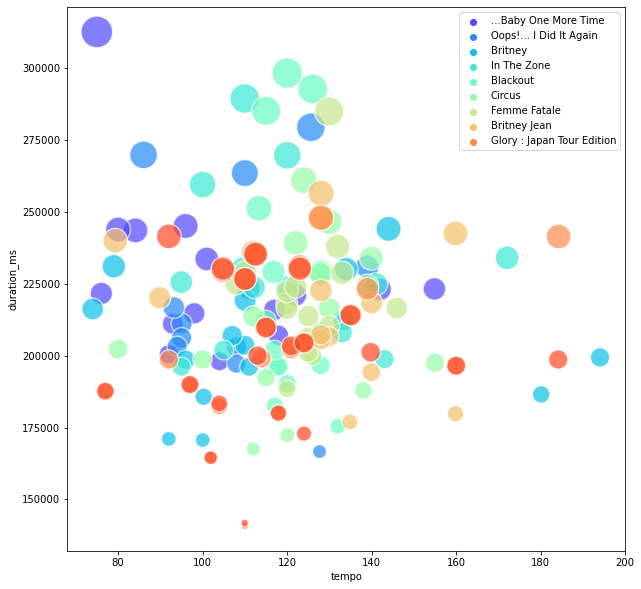

In [65]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df, x='tempo', y='duration_ms', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)